# Import Modules and Functions

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import datetime
from matplotlib.ticker import MultipleLocator
import astropy.units as u
from  astropy import constants
from scipy import interpolate
from scipy.interpolate import interp1d
from specutils import Spectrum1D
from specutils.manipulation import FluxConservingResampler

path_04 = '/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/2009_Analysis/'
path_22 = '/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/2022_Analysis/'
path_23 = '/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/2023_Analysis/'
path_24 = '/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/2024_Analysis/'

# Function that reads in the data from txt. files
def readTxt(file_path):
    # Initialize empty lists to be returned
    wavelength_list = []
    flux_list = []
    flux_err_list = []
    
    with open(file_path, 'r') as file:
        for line in file:
            # Check the row begins with a number - not holding a column title
            if line[0].isnumeric():
                # Split each line into separate values separated by one or more space or commas
                values = re.split(r'[\s,]+', line.strip())
                # Convert the values to floats and append them to the respective lists
                if len(values) > 1:
                    wavelength_list.append(float(values[0]))
                    flux_list.append(float(values[1]))
                    try:
                        flux_err_list.append(float(values[2]))
                    except:
                        flux_err_list.append(float(values[1])*0.1)
        # Convert to numpy array for easier manipulation
        wavelength_arr = np.array(wavelength_list)
        flux_arr = np.array(flux_list)
        flux_err_arr = np.array(flux_err_list)
    return(wavelength_arr, flux_arr, flux_err_arr)


# Integrate spectrum between wavelength ranges
def integrate_spectrum_trapezium(wavelength, flux, wl_min, wl_max):
    # Mask the wavelength and flux to select the range between wl_min and wl_max
    mask = (wavelength >= wl_min) & (wavelength <= wl_max)
    wl_selected = wavelength[mask]
    flux_selected = flux[mask]
    # Perform the integration using the trapezium rule
    integral = np.trapz(flux_selected, wl_selected, dx=0.1)
    return integral


# Find average filter flux
def average_flux(wavelength, flux, wl_min, wl_max):
    # Mask the wavelength and flux to select the range between wl_min and wl_max
    mask = (wavelength >= wl_min) & (wavelength <= wl_max)
    flux_selected = flux[mask]
    # Find average flux
    mean = np.mean(flux_selected)
    return mean


# Calculate apparent magnitude from flux
def calculate_filter_magnitude(wave, flux, band, filter_info):
    
    #f = integrate_spectrum_trapezium(wave, flux, filter_info.loc[band]['wav_low'], filter_info.loc[band]['wav_high'])
    f = average_flux(wave, flux, filter_info.loc[band]['wav_low'], filter_info.loc[band]['wav_high'])
    f0 = (filter_info.loc[band]['f0']*1e-9)
    magnitude = -2.5 * np.log10( f / f0 )
    
    return magnitude

# Function to convert MJD to datetime
def mjd_to_date(mjd):
    mjd_epoch = datetime.datetime(1858, 11, 17)
    return mjd_epoch + datetime.timedelta(days=mjd)

# Set the ticks and labels for the secondary x-axis
def mjd_formatter(x):
    date = mjd_to_date(x)
    return date.strftime('%Y')

def date_to_mjd(date):
    """
    Convert a given date to its corresponding Modified Julian Date (MJD).
    """
    # MJD epoch (November 17, 1858)
    mjd_epoch = datetime.datetime(1858, 11, 17, 0, 0, 0)
    # Calculate the difference in days
    delta = date - mjd_epoch
    # Return the number of days as MJD
    return delta.days + delta.seconds / 86400

# Phil's flux conversion from wavelength to frequency
def flam_to_fnu(flams,lams):
    # Charlottes: f_ν =  ((λ**2) / c )f_λ
    return flams*lams**2/(constants.c.to(u.AA/u.s)), constants.c.to(u.AA/u.s)/lams

def wave_to_freq(wave, flux_wave):
    freq = 3e10 / (wave*1e-8)
    flux_freq = flux_wave * ((wave*1e-8)**2 / 3e10)
    return(freq, flux_freq)

# Function that takes arrays of date and magnitude and returns arrays of daily averages
def average_daily_magnitude(mjd, mag, mag_err, ten_day_avg=False):
    int_mjd = np.floor(mjd).astype(int) # Convert MJD to integer days
    if ten_day_avg == True: 
        int_mjd = (int_mjd //10) * 10 # round down to nearest 10
    unique_days = np.unique(int_mjd) # Find unique days
    
    avg_mag = []
    avg_mag_err = []
    for day in unique_days:
        # Find average of daily measurements
        multiple_mag = np.where(int_mjd == day)[0] # Find indices of measurements taken on this day

        # Average mag value
        day_avg_mag = np.mean(mag[multiple_mag])
        avg_mag.append(day_avg_mag)
        
        # Sum together square of error/value then sqrt to propagate average mag errors
        error_sum = 0
        for day_index in multiple_mag:
            error_sum += (mag_err[day_index])**2
        day_avg_mag_err = 1/len(multiple_mag) * np.sqrt(error_sum)
        avg_mag_err.append(day_avg_mag_err)

    return unique_days, np.array(avg_mag), np.array(avg_mag_err)

# Import Data

In [6]:
z = 0.074550  # Redshift

# Spectra
file_path_2004 = '/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/Data/6df_spectra/6dFJ0245455-030450-S-VR-j2009.txt'
wave_04, flux_04, err_04 = readTxt(file_path_2004)
flux_04 = 0.024643971103449368*flux_04 * 1e-17 # scale to [OIII] of 2022
err_04 = 0.024643971103449368*err_04 * 1e-17

file_path_2022 = '/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/Data/10JYSElqi_spectra/10JYSElqi_gr4_2022-09-09T05h46h03s_final_red.txt'
wave_22, flux_22, err_22 = readTxt(file_path_2022)

file_path_2023 = '/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/Data/10JYSElqi_spectra/10JYSElqi_gr8_2023-09-08T05h29m47s_final_red.txt'
wave_23, flux_23, err_23 = readTxt(file_path_2023)

file_path_2024 = '/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/Data/10JYSElqi_spectra/28_August_2024_spec/10JYSElqi_WiFeS_20240828.csv'
wave_24, flux_24, err_24 = readTxt(file_path_2024)


# Spectroscopy Fitting Parameters
conti_results_04 = pd.read_csv(path_04 + 'mcmc_conti_results_host_sub.csv')
line_results_04 = pd.read_csv(path_04 + 'mcmc_line_results_host_sub.csv') # Individual line parameters
fur_results_04 = pd.read_csv(path_04 + 'mcmc_fur_results_host_sub.csv') # Combined line complex parameters

conti_results_22 = pd.read_csv(path_22 + 'mcmc_conti_results.csv')
line_results_22 = pd.read_csv(path_22 + 'mcmc_line_results.csv')
fur_results_22 = pd.read_csv(path_22 + 'mcmc_fur_results.csv')

conti_results_23 = pd.read_csv(path_23 + 'mcmc_conti_results.csv')
line_results_23 = pd.read_csv(path_23 + 'mcmc_line_results.csv')
fur_results_23 = pd.read_csv(path_23 + 'mcmc_fur_results.csv')

conti_results_24 = pd.read_csv(path_24 + 'mcmc_conti_results_host_sub.csv') # Host sub values are obtained by subtracting the 2022 host decomposition
line_results_24 = pd.read_csv(path_24 + 'mcmc_line_results_host_sub.csv')
fur_results_24 = pd.read_csv(path_24 + 'mcmc_fur_results_host_sub.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/2023_Analysis/mcmc_conti_results.csv'

# Plot Spectra

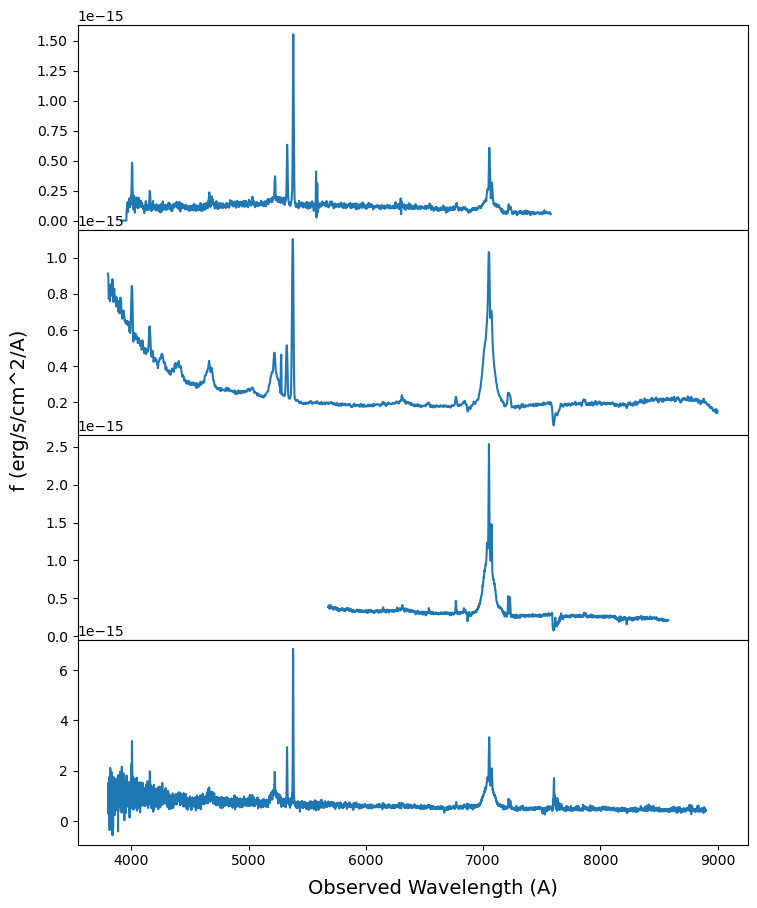

In [7]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(9, 11), sharex=True)

ax1.plot(wave_04, flux_04)
ax2.plot(wave_22, flux_22)
ax3.plot(wave_23, flux_23)
ax4.plot(wave_24, flux_24)

# Axis Labels
fig.text(0.55, 0.09, r'Observed Wavelength (A)', ha='center', fontsize=14)
fig.text(0.08, 0.53, 'f (erg/s/cm^2/A)', va='center', rotation='vertical', fontsize=14)

# Improve layout and show plot
fig.subplots_adjust(hspace=0, bottom=0.135, left=0.155)

plt.show()

# Resample 2024 spectra to reduce noise 6000+ -> 2500

Using specutils FluxConservingResample

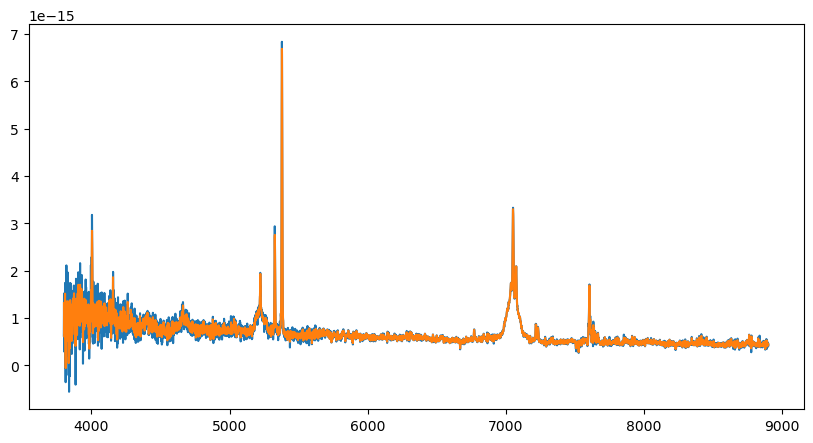

2.832584667959843e-13
2.8240274360875796e-13


In [8]:
input_spectra = Spectrum1D(
    flux = flux_24 * (u.erg / u.s / u.cm**2 / u.AA),
    spectral_axis = wave_24 * u.AA)
resample_grid = np.linspace(wave_24.min()+1, wave_24.max()-1, int(len(wave_24)/2))  * u.AA
flux_resample = FluxConservingResampler()
sampled_24_spectra = flux_resample(input_spectra, resample_grid)

plt.figure(figsize=[10,5])
plt.plot(wave_24, flux_24)
plt.plot(sampled_24_spectra.spectral_axis, sampled_24_spectra.flux)
plt.show()

# Check flux conservation by integrating between wavelengths
print(integrate_spectrum_trapezium(wave_24, flux_24, 6900, 7200))
print(integrate_spectrum_trapezium(sampled_24_spectra.spectral_axis.value, sampled_24_spectra.flux.value, 6900, 7200))

# Scale to 2024

Scale 22,23 to 2024 [NII], Scale 2004 to Catalina RTS V-band which follows Johnson UBV Photometry system

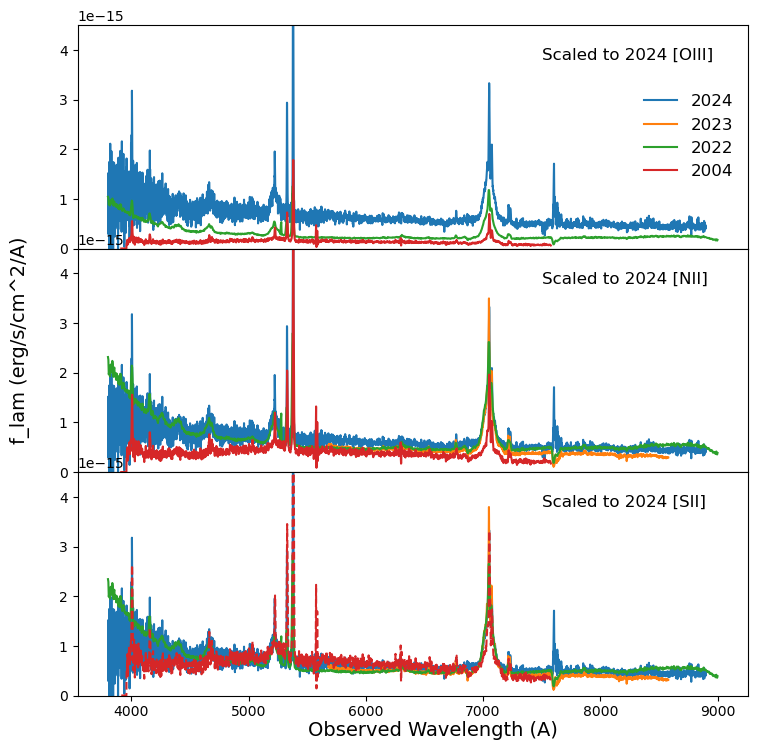

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9,9), sharex=True)

# Scale to [OIII]
ax1.plot(wave_24, flux_24, label='2024')
ax1.plot(wave_23, flux_23*100, label='2023')
ax1.plot(wave_22, flux_22/0.875815604, label='2022')
ax1.plot(wave_04, flux_04/0.871663039, label='2004')

# Scale to [NII]
ax2.plot(wave_24, flux_24)
ax2.plot(wave_23, flux_23/0.72472939)
ax2.plot(wave_22, flux_22/0.393831581)
ax2.plot(wave_04, flux_04/0.309511478)

# Scale to [SII]
ax3.plot(wave_24, flux_24)
ax3.plot(wave_23, flux_23/0.66748088)
ax3.plot(wave_22, flux_22/0.389140136)
ax3.plot(wave_04, flux_04/0.183294559, linestyle='--')

# Don't need to see narrow [OIII peak]
ax1.set_ylim(0, 4.5e-15)
ax2.set_ylim(0, 4.5e-15)
ax3.set_ylim(0, 4.5e-15)

# Add text labels
ax1.legend(loc='right', fontsize=12, frameon=False)
ax1.text(7500, 3.8e-15, 'Scaled to 2024 [OIII]', fontsize='12')
ax2.text(7500, 3.8e-15, 'Scaled to 2024 [NII]', fontsize='12')
ax3.text(7500, 3.8e-15, 'Scaled to 2024 [SII]', fontsize='12')

# Axis Labels
fig.text(0.55, 0.09, r'Observed Wavelength (A)', ha='center', fontsize=14)
fig.text(0.08, 0.53, r'f_lam (erg/s/cm^2/A)', va='center', rotation='vertical', fontsize=14)

# Improve layout and show plot
fig.subplots_adjust(hspace=0, bottom=0.135, left=0.155)

plt.show()

# Scale 2004 to Catalina (Johnson UBV Photometry)

Catalina V-band (first group of data points) average magnitude = 16.45347222222222

Corresponds to flux density 9.83e-16 erg/s/cm2/A

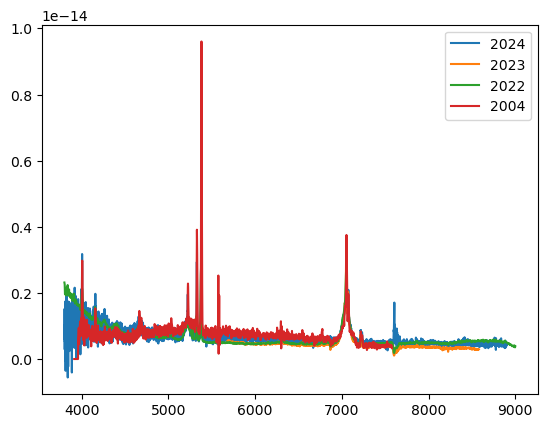

In [10]:
total = 0
count = 0
for i in range(len(wave_04)):
    if (wave_04[i] > 5000 and wave_04[i] < 6000): # roughly Johnson V-waveband 5000-7000
        total += flux_04[i]
        count+=1

avg_flux = total/count # NOTE: this is already scaled by the 0.02
aim_flux = 9.83e-16

# Create scaled flux arrays
flux_04_cat_scaled = flux_04 * aim_flux/avg_flux
flux_22_NII_scaled = flux_22/0.393831581
flux_23_NII_scaled = flux_23/0.72472939

# Scale to [NII]
plt.plot(wave_24, flux_24, label='2024')
plt.plot(wave_23, flux_23_NII_scaled, label='2023')
plt.plot(wave_22, flux_22_NII_scaled, label='2022')
plt.plot(wave_04, flux_04_cat_scaled, label='2004')
plt.legend()
plt.show()

# Inspired by 'What The Flux' - CFro

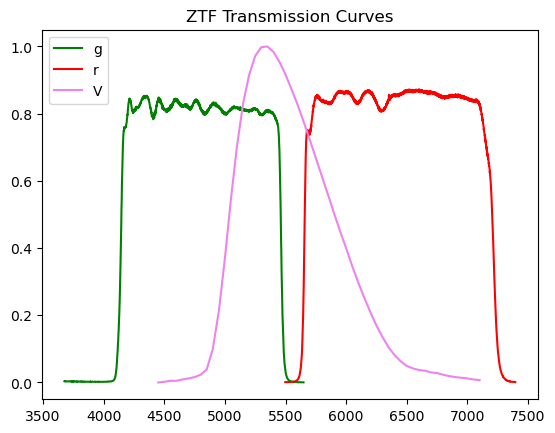

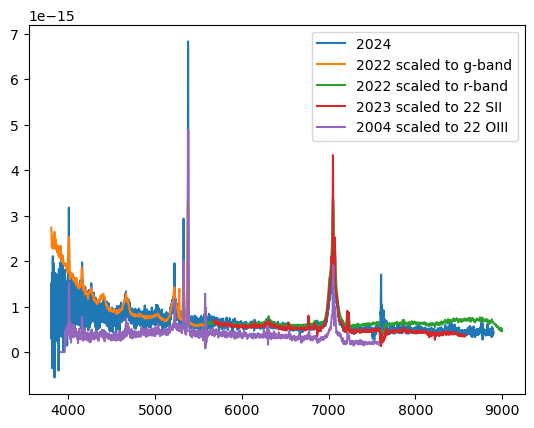

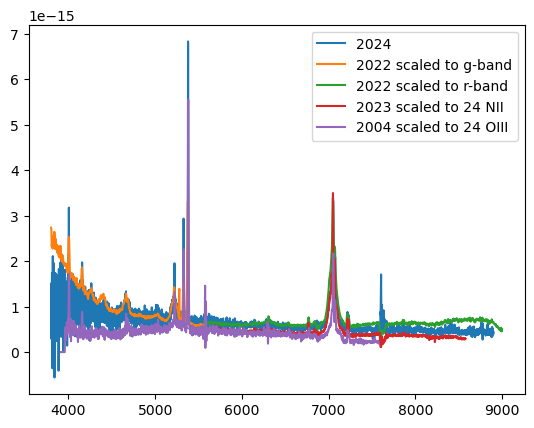

2004
Mag in ZTF-r: 16.983841815563906
Mag in ZTF-g: 17.3931266927033
Mag in Johnson-V: 16.99503428650558
2022
Mag in ZTF-r: 16.4459141116518
Mag in ZTF-g: 16.65013521927744
Mag in Johnson-V: 16.668459650943966
2024
Mag in ZTF-r: 16.512220577324584
Mag in ZTF-g: 16.8731811773485
Mag in Johnson-V: 16.684094770777907


In [11]:
def InterpolateFilter(filter_wave, filter_sens, spectra_wave):
    
    # Create an interpolator function for the second spectrum
    flux_interp = interp1d(filter_wave, filter_sens, kind='linear', bounds_error=False, fill_value="extrapolate")
    
    # Interpolate the second spectrum flux at the wavelengths of the first spectrum
    interpolated_filter_sens = np.clip(flux_interp(spectra_wave), 0, None)

    return(spectra_wave, interpolated_filter_sens)


file_path_ztf_r = '/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/Data/Photometric Transmission Curves/Palomar_ZTF.r.dat'
file_path_ztf_g = '/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/Data/Photometric Transmission Curves/Palomar_ZTF.g.dat'
file_path_johnson_V = '/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/Data/Photometric Transmission Curves/GCPD_Johnson.V_ADPS.dat'

ztf_r_trans = pd.read_csv(file_path_ztf_r, delimiter=' ', usecols=[0, 1], names=['wave', 'sens'], header=None)
ztf_g_trans = pd.read_csv(file_path_ztf_g, delimiter=' ', usecols=[0, 1], names=['wave', 'sens'], header=None)
johnson_V_trans = pd.read_csv(file_path_johnson_V, delimiter=' ', usecols=[0, 1], names=['wave', 'sens'], header=None)

plt.title('ZTF Transmission Curves')
plt.plot(ztf_g_trans['wave'], ztf_g_trans['sens'], color='green', label='g')
plt.plot(ztf_r_trans['wave'], ztf_r_trans['sens'], color='red', label='r')
plt.plot(johnson_V_trans['wave'], johnson_V_trans['sens'], color='violet', label='V')
plt.legend()
plt.show()


def mag_calc(wave_year, flux_year):
    r_wave, r_sens = InterpolateFilter(ztf_r_trans['wave'], ztf_r_trans['sens'], wave_year)
    g_wave, g_sens = InterpolateFilter(ztf_g_trans['wave'], ztf_g_trans['sens'], wave_year)
    V_wave, V_sens = InterpolateFilter(johnson_V_trans['wave'], johnson_V_trans['sens'], wave_year)
    
    V_sens = V_sens*0.9
    #print(V_sens[800])
    
    '''
    # Plot filter effect
    plt.title('ZTF Spectra Observation')
    plt.plot(wave_year, flux_year, color='black')
    plt.plot(wave_year, r_sens*flux_year, color='red')
    plt.plot(wave_year, g_sens*flux_year, color='green')
    plt.show()
    plt.title('Catalina Approximate Spectra Observation')
    plt.plot(wave_year, flux_year, color='black')
    plt.plot(wave_year, V_sens*flux_year, color='violet')
    plt.show()
    '''

    flux_dens_r = np.trapz(wave_year, r_sens*flux_year) / np.trapz(wave_year, r_sens)
    flux_dens_g = np.trapz(wave_year, g_sens*flux_year) / np.trapz(wave_year, g_sens)
    flux_dens_V = np.trapz(wave_year, V_sens*flux_year) / np.trapz(wave_year, V_sens)
    
    magnitude_r = -2.5 * np.log10( flux_dens_r / 2.64344e-9 )
    magnitude_g = -2.5 * np.log10( flux_dens_g / 4.75724e-9 )
    magnitude_V = -2.5 * np.log10( flux_dens_V / 3.58937e-9 )
    
    print('Mag in ZTF-r: ' + str(magnitude_r))
    print('Mag in ZTF-g: ' + str(magnitude_g))
    print('Mag in Johnson-V: ' + str(magnitude_V))


plt.plot(wave_24, flux_24, label='2024')
plt.plot(wave_22[:520], flux_22[:520] * 3.003, label='2022 scaled to g-band')
plt.plot(wave_22[520:], flux_22[520:] * 3.287, label='2022 scaled to r-band')
#plt.plot(wave_22[520:], flux_22[520:] * 3.145, label='2022 scaled to ZTF')
plt.plot(wave_23, flux_23 * 1.71, label='2023 scaled to 22 SII')
#plt.plot(wave_04, flux_04 * 5.638345599818253, label='2004 scaled to V-band')
plt.plot(wave_04, flux_04 * 3.145, label='2004 scaled to 22 OIII')
plt.legend()
plt.show()

plt.plot(wave_24, flux_24, label='2024')
plt.plot(wave_22[:520], flux_22[:520] * 3.003, label='2022 scaled to g-band')
plt.plot(wave_22[520:], flux_22[520:] * 3.287, label='2022 scaled to r-band')
#plt.plot(wave_22[520:], flux_22[520:] * 3.145, label='2022 scaled to ZTF')
plt.plot(wave_23, flux_23 / 0.724, label='2023 scaled to 24 NII')
#plt.plot(wave_04, flux_04 * 5.638345599818253, label='2004 scaled to V-band')
plt.plot(wave_04, flux_04 * 3.145 / 0.88, label='2004 scaled to 24 OIII')
plt.legend()
plt.show()

print('2004')
mag_calc(wave_04, flux_04*3.145/0.88)
print('2022')
mag_calc(wave_22, flux_22*3.145)
print('2024')
mag_calc(wave_24, flux_24)

In [ ]:
0.024643971103449368 * (3.145 / 0.88)

# Magnitude Calculations

m = -2.5 log(f/f0)

where f0 is a zeropoint flux used for calibration. I have different values foe each band/survey so I can test multiple.

ASASSN & Catalina v-band = Johnson-Cousins v-band


In [ ]:
# Filter wavelength ranges and zeropoint flux
filters = pd.DataFrame(columns=['wav_low','wav_high','f0'], index=['ztf_g','ztf_r','asassn_g','asassn_v','catalina_v','atlas_c','atlas_o'])

# UNITS: A, 10^-9 erg/s/cm^2/A
filters.loc['ztf_g']         = pd.Series({'wav_low':4100, 'wav_high':5500, 'f0':4.75724}) # f0 taken from SVO AB zeropoint values. Some taken from literature
filters.loc['ztf_r']         = pd.Series({'wav_low':5600, 'wav_high':7100, 'f0':2.64344})
filters.loc['asassn_g']      = pd.Series({'wav_low':4000, 'wav_high':5500, 'f0':5.12}) # unsure f0
filters.loc['asassn_v']      = pd.Series({'wav_low':5000, 'wav_high':6000, 'f0':3.64}) # Standard Johnson-Cousins v-band
filters.loc['catalina_v']    = pd.Series({'wav_low':5000, 'wav_high':6000, 'f0':3.64})
filters.loc['atlas_c']       = pd.Series({'wav_low':4200, 'wav_high':6500, 'f0':3.89323})
filters.loc['atlas_o']       = pd.Series({'wav_low':5600, 'wav_high':8200, 'f0':2.38902})

filters

In [20]:
# Apparent magnitudes from epoch spectra using different filters
magnitudes = pd.DataFrame(columns=['2004','2022','2023','2024'], index=['ztf_g','ztf_r','asassn_g','asassn_v','catalina_v','atlas_c','atlas_o'])
'''
# OIII scale
flux_04 = flux_04 / 0.871663039
flux_22 = flux_22 / 0.875815604

# NII scale
flux_04 = flux_04 / 0.309511477
flux_22 = flux_22 / 0.393831581
flux_23 = flux_23 / 0.724729392

# SII scale
flux_04 = flux_04 / 0.183294561
flux_22 = flux_22 / 0.389140136
flux_23 = flux_23 / 0.667480883
'''
'''
# Calculate magnitudes and populate dataframe - some flux values adjusted for known transmission curve sensitivities
magnitudes.loc['ztf_g']         = pd.Series({'2004': calculate_filter_magnitude(wave_04, flux_04, 'ztf_g', filters),
                                             '2022': calculate_filter_magnitude(wave_22, flux_22, 'ztf_g', filters),
                                             #'2023': calculate_filter_magnitude(wave_23, flux_23, 'ztf_g', filters),
                                             '2024': calculate_filter_magnitude(wave_24, flux_24, 'ztf_g', filters)})
magnitudes.loc['ztf_r']         = pd.Series({'2004': calculate_filter_magnitude(wave_04, flux_04, 'ztf_r', filters),
                                             '2022': calculate_filter_magnitude(wave_22, flux_22, 'ztf_r', filters),
                                             '2023': calculate_filter_magnitude(wave_23, flux_23, 'ztf_r', filters),
                                             '2024': calculate_filter_magnitude(wave_24, flux_24, 'ztf_r', filters)})
magnitudes.loc['asassn_g']      = pd.Series({'2004': calculate_filter_magnitude(wave_04, flux_04, 'asassn_g', filters),
                                             '2022': calculate_filter_magnitude(wave_22, flux_22, 'asassn_g', filters),
                                             #'2023': calculate_filter_magnitude(wave_23, flux_23, 'asassn_g', filters),
                                             '2024': calculate_filter_magnitude(wave_24, flux_24, 'asassn_g', filters)})
magnitudes.loc['asassn_v']      = pd.Series({'2004': calculate_filter_magnitude(wave_04, flux_04, 'asassn_v', filters),
                                             '2022': calculate_filter_magnitude(wave_22, flux_22, 'asassn_v', filters),
                                             '2023': calculate_filter_magnitude(wave_23, flux_23, 'asassn_v', filters),
                                             '2024': calculate_filter_magnitude(wave_24, flux_24, 'asassn_v', filters)})
magnitudes.loc['catalina_v']    = pd.Series({'2004': calculate_filter_magnitude(wave_04, flux_04_cat_scaled, 'catalina_v', filters),
                                             '2022': calculate_filter_magnitude(wave_22, flux_22, 'catalina_v', filters),
                                             '2023': calculate_filter_magnitude(wave_23, flux_23, 'catalina_v', filters),
                                             '2024': calculate_filter_magnitude(wave_24, flux_24, 'catalina_v', filters)})
magnitudes.loc['atlas_c']       = pd.Series({'2004': calculate_filter_magnitude(wave_04, flux_04, 'atlas_c', filters),
                                             '2022': calculate_filter_magnitude(wave_22, flux_22, 'atlas_c', filters),
                                             '2023': calculate_filter_magnitude(wave_23, flux_23, 'atlas_c', filters),
                                             '2024': calculate_filter_magnitude(wave_24, flux_24, 'atlas_c', filters)})
magnitudes.loc['atlas_o']       = pd.Series({'2004': calculate_filter_magnitude(wave_04, flux_04, 'atlas_o', filters),
                                             '2022': calculate_filter_magnitude(wave_22, flux_22, 'atlas_o', filters),
                                             '2023': calculate_filter_magnitude(wave_23, flux_23, 'atlas_o', filters),
                                             '2024': calculate_filter_magnitude(wave_24, flux_24, 'atlas_o', filters)})
'''

# New magnitudes based on NII scaled and Catalina calibrated flux - Might use the online Catalina conversion instead of this calculated one
# Calculate magnitudes and populate dataframe - some flux values adjusted for known transmission curve sensitivities
magnitudes.loc['ztf_g']         = pd.Series({'2004': calculate_filter_magnitude(wave_04, flux_04_cat_scaled, 'ztf_g', filters),
                                             '2022': calculate_filter_magnitude(wave_22, flux_22_NII_scaled, 'ztf_g', filters),
                                             '2024': calculate_filter_magnitude(wave_24, flux_24, 'ztf_g', filters)})
magnitudes.loc['ztf_r']         = pd.Series({'2004': calculate_filter_magnitude(wave_04, flux_04_cat_scaled, 'ztf_r', filters),
                                             '2022': calculate_filter_magnitude(wave_22, flux_22_NII_scaled, 'ztf_r', filters),
                                             '2023': calculate_filter_magnitude(wave_23, flux_23_NII_scaled, 'ztf_r', filters),
                                             '2024': calculate_filter_magnitude(wave_24, flux_24, 'ztf_r', filters)})
magnitudes.loc['asassn_g']      = pd.Series({'2004': calculate_filter_magnitude(wave_04, flux_04_cat_scaled, 'asassn_g', filters),
                                             '2022': calculate_filter_magnitude(wave_22, flux_22_NII_scaled, 'asassn_g', filters),
                                             '2024': calculate_filter_magnitude(wave_24, flux_24, 'asassn_g', filters)})
magnitudes.loc['asassn_v']      = pd.Series({'2004': calculate_filter_magnitude(wave_04, flux_04_cat_scaled, 'asassn_v', filters),
                                             '2022': calculate_filter_magnitude(wave_22, flux_22_NII_scaled, 'asassn_v', filters),
                                             '2023': calculate_filter_magnitude(wave_23, flux_23_NII_scaled, 'asassn_v', filters),
                                             '2024': calculate_filter_magnitude(wave_24, flux_24, 'asassn_v', filters)})
magnitudes.loc['catalina_v']    = pd.Series({'2004': calculate_filter_magnitude(wave_04, flux_04_cat_scaled, 'catalina_v', filters),
                                             '2022': calculate_filter_magnitude(wave_22, flux_22_NII_scaled, 'catalina_v', filters),
                                             '2023': calculate_filter_magnitude(wave_23, flux_23_NII_scaled, 'catalina_v', filters),
                                             '2024': calculate_filter_magnitude(wave_24, flux_24, 'catalina_v', filters)})
magnitudes.loc['atlas_c']       = pd.Series({'2004': calculate_filter_magnitude(wave_04, flux_04_cat_scaled, 'atlas_c', filters),
                                             '2022': calculate_filter_magnitude(wave_22, flux_22_NII_scaled, 'atlas_c', filters),
                                             '2023': calculate_filter_magnitude(wave_23, flux_23_NII_scaled, 'atlas_c', filters),
                                             '2024': calculate_filter_magnitude(wave_24, flux_24, 'atlas_c', filters)})
magnitudes.loc['atlas_o']       = pd.Series({'2004': calculate_filter_magnitude(wave_04, flux_04_cat_scaled, 'atlas_o', filters),
                                             '2022': calculate_filter_magnitude(wave_22, flux_22_NII_scaled, 'atlas_o', filters),
                                             '2023': calculate_filter_magnitude(wave_23, flux_23_NII_scaled, 'atlas_o', filters),
                                             '2024': calculate_filter_magnitude(wave_24, flux_24, 'atlas_o', filters)})

magnitudes = magnitudes.T
magnitudes.insert(loc=0, column='mjd', value=[53355, 59831, 60195, 60550]) # Add column of observation dates

magnitudes.to_csv('flux_calibrate_mag.csv', index=False)
magnitudes

NameError: name 'filters' is not defined

In [ ]:
average_flux(wave_22, flux_22, 5000, 6000)

# Plot Obtained Magnitudes to Compare Photometry

NameError: name 'magnitudes' is not defined

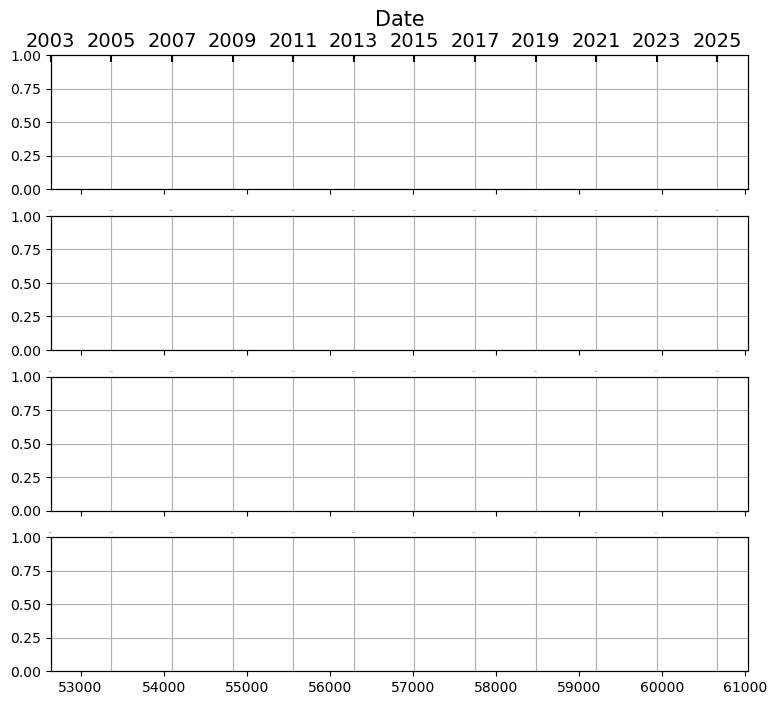

In [12]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(9, 8), sharex=True)
axtop1 = ax1.twiny() # Create a secondary x-axis on the top
axtop2 = ax2.twiny()
axtop3 = ax3.twiny()
axtop4 = ax4.twiny()

# Get the range of MJD values and corresponding years
mjd_start = 53000
mjd_end = 60800
year_start = mjd_to_date(mjd_start).year # custom adjust years for this lightcurve
year_end = mjd_to_date(mjd_end).year + 1 # round up with +1
mjd_start = date_to_mjd(datetime.datetime(year_start, 1, 1)) # update mjd start and end based on rounding to years
mjd_end = date_to_mjd(datetime.datetime(year_end, 1, 1))

epochs = [53355, 59831, 60195, 60550]

# Create a list of years with the desired interval (e.g., every 5 years)
year_interval = 2
year_ticks = np.arange(mjd_start, mjd_end, year_interval*365)
year_labels = np.arange(year_start, year_end+1, year_interval)

# Format the secondary x-axis to show years and plot year grid lines
axtop1.tick_params(axis='both', direction='in', which='major', labelsize=14, length=5, width=1.5)
axtop1.set_xlabel('Date', fontsize=15)
ax1.set_xlim(mjd_start, mjd_end)
axtop1.set_xlim(ax1.get_xlim())
axtop1.set_xticks(year_ticks)
axtop1.set_xticklabels(year_labels)
axtop1.grid(axis='x')
ax1.grid(axis='y')
axtop2.tick_params(axis='both', which='major', labelsize=0, length=0, width=0)
ax2.set_xlim(mjd_start, mjd_end)
axtop2.set_xlim(ax2.get_xlim())
axtop2.set_xticks(year_ticks)
axtop2.set_xticklabels(year_labels)
axtop2.grid(axis='x')
ax2.grid(axis='y')
axtop3.tick_params(axis='both', which='major', labelsize=0, length=0, width=0)
ax3.set_xlim(mjd_start, mjd_end)
axtop3.set_xlim(ax3.get_xlim())
axtop3.set_xticks(year_ticks)
axtop3.set_xticklabels(year_labels)
axtop3.grid(axis='x')
ax3.grid(axis='y')
axtop4.tick_params(axis='both', which='major', labelsize=0, length=0, width=0)
ax4.set_xlim(mjd_start, mjd_end)
axtop4.set_xlim(ax4.get_xlim())
axtop4.set_xticks(year_ticks)
axtop4.set_xticklabels(year_labels)
axtop4.grid(axis='x')
ax4.grid(axis='y', which='both')


# Plot the first light curve
axtop1.plot(epochs, magnitudes['catalina_v'].to_numpy(), 'o', color='black', label='v-band', markersize=10)
ax1.yaxis.set_major_locator(MultipleLocator(1))
ax1.invert_yaxis()
#ax1.set_ylim(17.45, 15.55)
ax1.tick_params(axis='y', direction='in', which='major', labelsize=14, length=5, width=1.5)

# Plot the second light curve
axtop2.plot(epochs, magnitudes['asassn_v'].to_numpy(), 'o', color='black', label='v-band', markersize=10)
axtop2.plot(epochs, magnitudes['asassn_g'].to_numpy(), 'o', color='limegreen', label='g-band', markersize=10)
axtop2.yaxis.set_major_locator(MultipleLocator(1))
ax2.invert_yaxis()
#ax2.set_ylim(17.95, 15.05)
ax2.tick_params(axis='y', direction='in', which='major', labelsize=14, length=5, width=1.5)

# Plot the third light curve
axtop3.plot(epochs, magnitudes['ztf_r'].to_numpy(), 'o', color='red', label='r-band', markersize=10)
axtop3.plot(epochs, magnitudes['ztf_g'].to_numpy(), 'o', color='limegreen', label='g-band', markersize=10)
axtop3.yaxis.set_major_locator(MultipleLocator(1))
ax3.invert_yaxis()
ax3.tick_params(axis='y', direction='in', which='major', labelsize=14, length=5, width=1.5)

# Plot the fourth light curve
axtop4.plot(epochs, magnitudes['atlas_o'].to_numpy(), 'o', color='orange', label='o-band', markersize=10)
axtop4.plot(epochs, magnitudes['atlas_c'].to_numpy(), 'o', color='cyan', label='c-band', markersize=10)
axtop4.yaxis.set_minor_locator(MultipleLocator(1))
ax4.invert_yaxis()
ax4.tick_params(axis='both', direction='in', which='major', labelsize=14, length=5, width=1.5)


# Axis Labels
fig.text(0.55, 0.09, 'Modified Julian Date (MJD)', ha='center', fontsize=16)
fig.text(0.08, 0.53, 'Magnitude', va='center', rotation='vertical', fontsize=16)

# Legends
axtop1.legend(fontsize='large')
axtop2.legend(fontsize='large')
axtop3.legend(fontsize='large')
#axtop1.text(53550, 17.32, 'Catalina RTS (Optical)', fontsize=14)
#axtop2.text(53550, 17.75, 'ASAS-SN (Optical)', fontsize=14)
#axtop3.text(53550, 17.62, 'ALeRCE ZTF (Optical)', fontsize=14)
#axtop4.text(53550, 22.15, 'ATLAS (Optical)', fontsize=14)

# Improve layout and show plot
fig.subplots_adjust(hspace=0, bottom=0.155, left=0.175)

# Save figure
custom_path = "/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/MyPlots/"
custom_filename = "CalculatingApparentMagnitude.png"
save_path = custom_path + custom_filename
#plt.savefig(save_path)
plt.show()

# Import Photometry to Calibrate (Catalina RTS, ZTF)

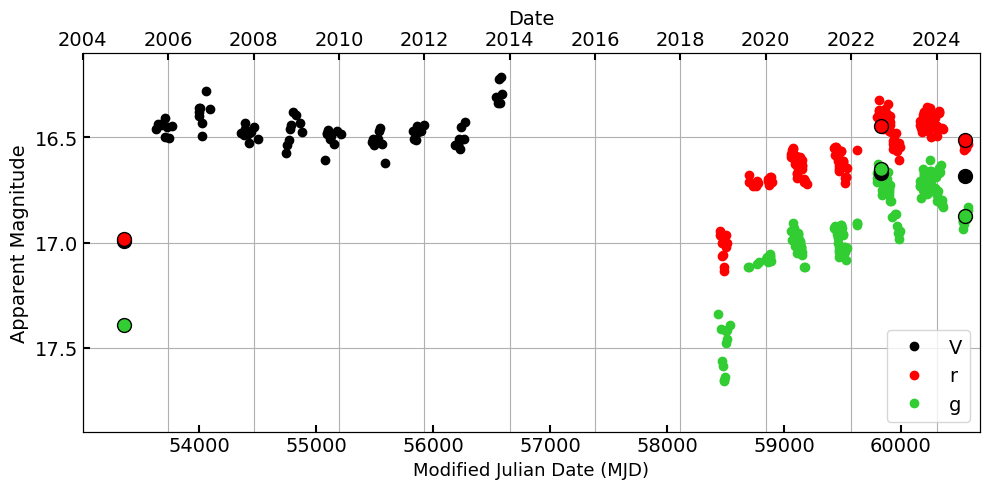

In [17]:
# File paths
catalina_file_path = '/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/Data/CRTS_27-07-24.csv'
ztfsnad_file_path = '/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/Data/ZTF18abuamgo_20240927/detections.csv'

# Read files into dataframe
catalina_df = pd.read_csv(catalina_file_path)
ztfsnad_df = pd.read_csv(ztfsnad_file_path)

# Catalina Data Handling
mjd_catalina = catalina_df['MJD']
mag_catalina = catalina_df['Mag']
mag_err_catalina = catalina_df['Magerr']
avg_mjd_catalina, avg_mag_catalina, avg_mag_err_catalina = average_daily_magnitude(mjd_catalina, mag_catalina, mag_err_catalina) # Compute daily averaged values

# ZTF Data Handling
g_band = ztfsnad_df[ztfsnad_df['fid']==1] # First split into the 2 bands stored
r_band = ztfsnad_df[ztfsnad_df['fid']==2]
mjd_ztf_r = r_band['mjd']
mjd_ztf_g = g_band['mjd']
mag_ztf_r = r_band['mag_corr']
mag_ztf_g = g_band['mag_corr']

epochs = [53355, 59831, 60550]
cat_mag = [17.13382760613017, 16.668459650943966, 16.684094770777907]
ztf_r_mag = [17.122635135188485, 16.4459141116518, 16.512220577324584]
ztf_g_mag = [17.53192001232788, 16.65013521927744, 16.8731811773485]

# Plot Calibration Photometry (ZTF & Catalina)
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.yaxis.set_major_locator(MultipleLocator(0.5)) # Set y-axis major ticks to 0.5 steps
ax1.invert_yaxis() # Invert the y-axis
ax2 = ax1.twiny() # Create a secondary x-axis on the top

# Get the range of MJD values and corresponding years
mjd_start = mjd_catalina.min()-300
mjd_end = mjd_ztf_g.max() # modified to include 2024 label + 200
year_start = mjd_to_date(mjd_start).year
year_end = mjd_to_date(mjd_end).year + 1 # round up with +1
mjd_start = date_to_mjd(datetime.datetime(year_start, 1, 1)) # update mjd start and end based on rounding to years
mjd_end = date_to_mjd(datetime.datetime(year_end, 1, 1))

# Create a list of years with the desired interval (e.g., every 5 years)
year_interval = 2
year_ticks = np.arange(mjd_start, mjd_end, year_interval*365)
year_labels = np.arange(year_start, year_end+1, year_interval)

# Format the secondary x-axis to show years
ax1.set_xlim(mjd_start, mjd_end)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(year_ticks)
ax2.set_xticklabels(year_labels)
ax2.set_xlabel('Date', fontsize=14)

ax1.tick_params(axis='both', direction='in', which='major', right=False, labelsize=14, length=5, width=1.5)
ax2.tick_params(axis='both', direction='in', which='major', labelsize=14, length=5, width=1.5)
ax1.set_ylim(17.9, 16.1)
ax2.grid(axis='x')
ax1.grid(axis='y')

# Plot Photometry
ax2.plot(avg_mjd_catalina, avg_mag_catalina, 'o', color='black', label='V')
ax2.plot(mjd_ztf_r, mag_ztf_r, 'o', color='red', label='r')
ax2.plot(mjd_ztf_g, mag_ztf_g, 'o', color='limegreen', label='g')

# Plot derived magnitudes
#ax2.plot(epochs[0], magnitudes['catalina_v'].to_numpy()[0], 'o', color='yellow', markersize=10) # 2004 Catalina V-
#ax2.plot(epochs[1:], magnitudes['ztf_g'].to_numpy()[1:], 'o', color='yellow', markersize=10) # 2022,24 ZTF g-
#ax2.plot(epochs[1:], magnitudes['ztf_r'][1:].to_numpy(), 'o', color='yellow', markersize=10) # 2022,23,24 ZTF r-

# Obtained from calculating similar to Cfro What the Flux!
#2004
ztf_r_04 = 16.983841815563906
ztf_g_04 = 17.3931266927033
johnson_V_04 = 16.99503428650558
#2022
ztf_r_22 = 16.4459141116518
ztf_g_22 = 16.65013521927744
johnson_V_22 = 16.668459650943966
#2024
ztf_r_24 = 16.512220577324584
ztf_g_24 = 16.8731811773485
johnson_V_24 = 16.684094770777907

ax2.plot(epochs, [16.99503428650558, 16.668459650943966, 16.684094770777907], 'o', color='black', markeredgewidth=1, markeredgecolor='black', markersize=10) # Catalina V
ax2.plot(epochs, [16.983841815563906, 16.4459141116518, 16.512220577324584], 'o', color='red', markeredgewidth=1, markeredgecolor='black', markersize=10) # ztf r
ax2.plot(epochs, [17.3931266927033, 16.65013521927744, 16.8731811773485], 'o', color='limegreen', markeredgewidth=1, markeredgecolor='black', markersize=10) # ztf g

ax1.set_xlabel('Modified Julian Date (MJD)', fontsize=13)
ax1.set_ylabel('Apparent Magnitude', fontsize=14)


# Lines marking spectroscopy
#ax1.vlines(59830, 17.9, 15.6, linestyle='--', color='black', linewidth=2) # Data spectra was recorded
#ax2.set_ylim(17.8, 16.2)

ax2.legend(frameon=True, loc='lower right', fontsize=14)
fig.tight_layout()
plt.show()

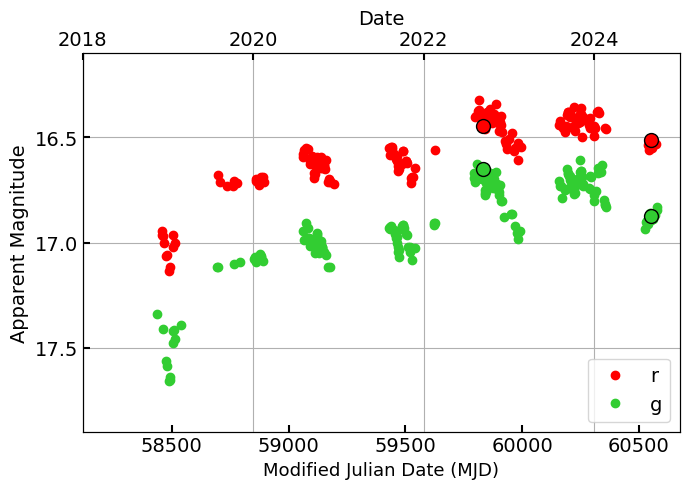

In [19]:
# Plot Calibration Photometry (ZTF & Catalina)
fig, ax1 = plt.subplots(figsize=(7,5))
ax1.yaxis.set_major_locator(MultipleLocator(0.5)) # Set y-axis major ticks to 0.5 steps
ax1.invert_yaxis() # Invert the y-axis
ax2 = ax1.twiny() # Create a secondary x-axis on the top

# Get the range of MJD values and corresponding years
mjd_start = mjd_ztf_g.min()-300
mjd_end = mjd_ztf_g.max() # modified to include 2024 label + 200
year_start = mjd_to_date(mjd_start).year
year_end = mjd_to_date(mjd_end).year + 1 # round up with +1
mjd_start = date_to_mjd(datetime.datetime(year_start, 1, 1)) # update mjd start and end based on rounding to years
mjd_end = date_to_mjd(datetime.datetime(year_end, 1, 1))

# Create a list of years with the desired interval (e.g., every 5 years)
year_interval = 2
year_ticks = np.arange(mjd_start, mjd_end, year_interval*365)
year_labels = np.arange(year_start, year_end+1, year_interval)

# Format the secondary x-axis to show years
ax1.set_xlim(mjd_start, mjd_end)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(year_ticks)
ax2.set_xticklabels(year_labels)
ax2.set_xlabel('Date', fontsize=14)

ax1.tick_params(axis='both', direction='in', which='major', right=False, labelsize=14, length=5, width=1.5)
ax2.tick_params(axis='both', direction='in', which='major', labelsize=14, length=5, width=1.5)
ax1.set_ylim(17.9, 16.1)
ax2.grid(axis='x')
ax1.grid(axis='y')

# Plot Photometry
ax2.plot(mjd_ztf_r, mag_ztf_r, 'o', color='red', label='r')
ax2.plot(mjd_ztf_g, mag_ztf_g, 'o', color='limegreen', label='g')

# Obtained from calculating similar to Cfro What the Flux!
ax2.plot(epochs, [16.983841815563906, 16.4459141116518, 16.512220577324584], 'o', color='red', markeredgewidth=1, markeredgecolor='black', markersize=10) # ztf r
ax2.plot(epochs, [17.3931266927033, 16.65013521927744, 16.8731811773485], 'o', color='limegreen', markeredgewidth=1, markeredgecolor='black', markersize=10) # ztf g

ax1.set_xlabel('Modified Julian Date (MJD)', fontsize=13)
ax1.set_ylabel('Apparent Magnitude', fontsize=14)


# Lines marking spectroscopy
#ax1.vlines(59830, 17.9, 15.6, linestyle='--', color='black', linewidth=2) # Data spectra was recorded
#ax2.set_ylim(17.8, 16.2)

ax2.legend(frameon=True, loc='lower right', fontsize=14)
fig.tight_layout()
plt.show()

# ZTF Magnitude Comparison with Transmission Curves

In [ ]:
file_path_ztf_r = '/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/Data/Photometric Transmission Curves/Palomar_ZTF.r.dat'
file_path_ztf_g = '/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/Data/Photometric Transmission Curves/Palomar_ZTF.g.dat'

ztf_r_trans = pd.read_csv(file_path_ztf_r, delimiter=' ', usecols=[0, 1], names=['wave', 'sens'], header=None)
ztf_g_trans = pd.read_csv(file_path_ztf_g, delimiter=' ', usecols=[0, 1], names=['wave', 'sens'], header=None)

In [ ]:
plt.plot(ztf_g['wave'], ztf_g['sens'], color='green')
plt.plot(ztf_r['wave'], ztf_r['sens'], color='red')
plt.show()

magnitudes[['ztf_g', 'ztf_r']]

In [ ]:
calculate_filter_magnitude(wave_24, flux_24, 'ztf_g', filters)

In [ ]:
37/5